In [6]:

import os
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes"
os.chdir(path)

from Preprocessing_Application_N import DataPreprocessor



server = 'reporting-db.nystartfinans.net'
database = 'reporting-db'
username = 'Andreas'
password = 'nCq8Sg@1lYnd(E'
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data/Loan Portfolio Deli.sql"
driver = '{ODBC Driver 17 for SQL Server}'  # This is an example for SQL Server, adjust according to your database and installed ODBC driver


# Initialize DataPreprocessor with all required parameters, including the driver
processor = DataPreprocessor(server, database, username, password, driver)

df = processor.fetch_data_from_sql(path)

#df.to_csv('BSC_Today.csv', index=False)

/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, con=self.conn)


THE SQL CODE NEEDS TO BE WRITEN IN CTE STYLE, IF NOT THIS SETUP WILL NOT WORK

In [7]:
df

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,...,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,Score,RiskClass
0,2024-01-31,1,7116833,CLOSED,0.00,49,2019-12-18,159,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2024-01-31,1,7715436,CLOSED,0.00,23,2022-02-10,174,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,2024-01-31,1,7841190,OPEN,293195.39,14,2022-11-24,180,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.484099,E3
3,2023-12-31,1,5643838,OPEN,163194.06,57,2019-03-06,122,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.877308,E3
4,2023-12-31,1,7686272,CLOSED,0.00,25,2021-11-03,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55091,2023-11-30,1,5002571,FROZEN,282184.10,86,2016-09-06,122,1,0,...,87.0,87.0,87.0,282184.1,282184.1,282184.1,282184.1,282184.1,100.000000,E8
55092,2023-11-30,1,7119779,FROZEN,89007.90,45,2020-02-13,162,0,0,...,46.0,46.0,46.0,89007.9,89007.9,89007.9,89007.9,89007.9,100.000000,E8
55093,2023-11-30,1,5034442,CLOSED,0.00,73,2017-10-04,112,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
55094,2023-11-30,1,7955362,CLOSED,0.00,2,2023-09-11,178,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [9]:
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data"
os.chdir(path)

df.to_csv('BSC_Today.csv', index=False)



In [10]:
df

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,...,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,Score,RiskClass
0,2024-01-31,1,7116833,CLOSED,0.00,49,2019-12-18,159,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2024-01-31,1,7715436,CLOSED,0.00,23,2022-02-10,174,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,2024-01-31,1,7841190,OPEN,293195.39,14,2022-11-24,180,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.484099,E3
3,2023-12-31,1,5643838,OPEN,163194.06,57,2019-03-06,122,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.877308,E3
4,2023-12-31,1,7686272,CLOSED,0.00,25,2021-11-03,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55091,2023-11-30,1,5002571,FROZEN,282184.10,86,2016-09-06,122,1,0,...,87.0,87.0,87.0,282184.1,282184.1,282184.1,282184.1,282184.1,100.000000,E8
55092,2023-11-30,1,7119779,FROZEN,89007.90,45,2020-02-13,162,0,0,...,46.0,46.0,46.0,89007.9,89007.9,89007.9,89007.9,89007.9,100.000000,E8
55093,2023-11-30,1,5034442,CLOSED,0.00,73,2017-10-04,112,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
55094,2023-11-30,1,7955362,CLOSED,0.00,2,2023-09-11,178,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [11]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt

In [12]:
path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/1. Data"
os.chdir(path)

df = pd.read_csv('BSC_Today.csv')


main = df[df.CoappFlag == 0]

co = df[df.CoappFlag == 1]

main = main[~main.AccountNumber.isin(co.AccountNumber)]

df = pd.concat([main,co])

# This was just a control to reconsile the number of accounts
# konton = df[ (df.AccountStatus.isin(['OPEN','FROZEN'])) & (df.SnapshotDate == max(df.SnapshotDate))   ]

In [78]:
df[df.AccountNumber == 7156474].sort_values('MOB')

,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,NoKronofogden,SSN,CurrentDelinquencyStatus,FBE,TimeSince30,TimeSince60,TimeSince90,TimeSince120,Ever30In6Months,Ever30In12Months,Ever30,Ever60In6Months,Ever60In12Months,Ever60,Ever90In6Months,Ever90In12Months,Ever90,Ever120In6Months,Ever120In12Months,Ever120,WorstDelinquency6M,WorstDelinquency12M,WorstDelinquency,TimeSinceFBE,EverFBEIn6Months,EverFBEIn12Months,EverFBEIn24Months,EverFBEIn36Months,EverFBEIn48Months,EverFBE,Ever30After12Months,Ever60After12Months,Ever90After12Months,Ever120After12Months,FrozenAfter12Months,Ever30After24Months,Ever60After24Months,Ever90After24Months,Ever120After24Months,FrozenAfter24Months,Ever30After36Months,Ever60After36Months,Ever90After36Months,Ever120After36Months,FrozenAfter36Months,Ever30After48Months,Ever60After48Months,Ever90After48Months,FrozenAfter48Months,TimeToFirst30,TimeToFirst60,TimeToFirst90,TimeToFirst120,TimeToFirstFrozen,ExposureAtFirst30,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,Score,RiskClass
51210,2023-11-30,1,7156474,FROZEN,99481.01,43,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,44.0,44.0,44.0,44.0,44.0,99481.01,99481.01,99481.01,99481.01,99481.01,100.0,E8
51940,2023-12-31,1,7156474,FROZEN,99481.01,44,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,45.0,45.0,45.0,45.0,45.0,99481.01,99481.01,99481.01,99481.01,99481.01,100.0,E8
49947,2024-01-31,1,7156474,FROZEN,99198.69,45,2020-04-22,155,0,0,1,38209C198E7E5DE90EA46DCD60CD5C340CBEF7BE3EA799...,9,0,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,5,5,5,NaN,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,46.0,46.0,46.0,46.0,46.0,99198.69,99198.69,99198.69,99198.69,99198.69,100.0,E8


In [14]:
coefficients = np.array([-0.44414603,  0.18778622 , 0.3539554 ,  0.70178643])
intercept = np.array([0])


# Sample DataFrame (Assuming you already have this in place)
pd_ = df.copy()

# Coefficients and Intercept from the Logistic Regression model


print("Coefficients:", coefficients)
print("Intercept:", intercept)


# Compute the Z values using your logistic regression model
pd_['Z'] = (pd_.CoappFlag * coefficients[0] +
            pd_.Ever30In6Months * coefficients[1] + 
            pd_.WorstDelinquency6M * coefficients[2] +
            pd_.CurrentDelinquencyStatus * coefficients[3] +

            intercept[0]) 

# Compute the original probabilities
pd_['P'] = pd_['Z'].apply(lambda x: 1 / (1 + np.exp(-x)))

# Coefficients and Intercept from the Calibration model
calibration_coef = 9.82696528
calibration_intercept = -8.57437634


print("Coefficient:", calibration_coef)
print("Intercept:", calibration_intercept)

# Using the original probabilities to calibrate them with the calibration model
pd_['Z_calibrated'] = pd_['P'].apply(lambda x: x * calibration_coef + calibration_intercept)

# Compute the calibrated probabilities
pd_['BehaviourModel'] = pd_['Z_calibrated'].apply(lambda x: 1 / (1 + np.exp(-x)))


pd_

Coefficients: [-0.44414603  0.18778622  0.3539554   0.70178643]
Intercept: [0]
Coefficient: 9.82696528
Intercept: -8.57437634


,SnapshotDate,IsMonthEnd,AccountNumber,AccountStatus,CurrentAmount,MOB,DisbursedDate,RemainingTenor,CoappFlag,Kronofogden,...,ExposureAtFirst60,ExposureAtFirst90,ExposureAtFirst120,base1,Score,RiskClass,Z,P,Z_calibrated,BehaviourModel
1,2024-01-31,1,7715436,CLOSED,0.00,23,2022-02-10,174,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.500000,-3.660894,0.025065
4,2023-12-31,1,7686272,CLOSED,0.00,25,2021-11-03,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.500000,-3.660894,0.025065
5,2024-01-31,1,5311071,CLOSED,0.00,67,2018-06-29,111,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.500000,-3.660894,0.025065
7,2023-12-31,1,7261803,CLOSED,0.00,31,2021-05-19,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.500000,-3.660894,0.025065
8,2023-12-31,1,7849581,OPEN,159516.23,12,2022-12-12,131,0,0,...,NaN,NaN,NaN,NaN,4.595843,E4,0.353955,0.587576,-2.800283,0.057309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55081,2023-12-31,1,7396070,OPEN,101214.67,52,2019-08-21,44,1,0,...,NaN,NaN,NaN,NaN,1.484099,E3,-0.444146,0.390753,-4.734455,0.008711
55087,2023-11-30,1,5343314,CLOSED,0.00,63,2018-08-17,122,1,0,...,0.00,0.00,0.00,0.00,NaN,NaN,7.829495,0.999602,1.248681,0.777071
55088,2023-11-30,1,7663727,FROZEN,258448.66,48,2019-11-29,89,1,0,...,258448.66,258448.66,258448.66,258448.66,100.000000,E8,7.829495,0.999602,1.248681,0.777071
55090,2023-11-30,1,7697147,FROZEN,358047.14,23,2021-12-06,165,1,1,...,358047.14,358047.14,358047.14,358047.14,100.000000,E8,7.829495,0.999602,1.248681,0.777071


In [15]:
see = pd_[pd_.Score >-1]

## Without when the accounts are Zero after CLOSED

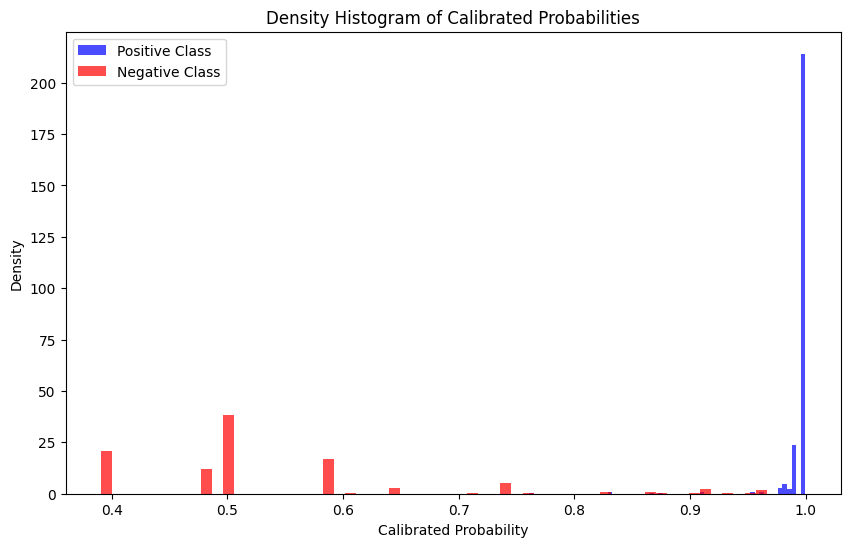

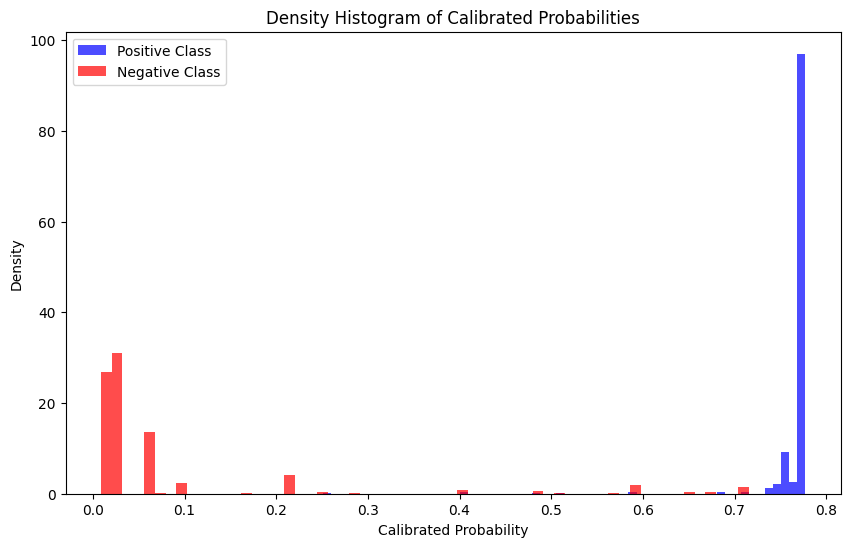

In [16]:
# Get the calibrated probabilities
calibrated_probabilities = see['P']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=60, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=60, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()

# Get the calibrated probabilities
calibrated_probabilities = see['BehaviourModel']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=60, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=60, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()



## ALL ACCOUNTS WITH CLOSED --> Zero

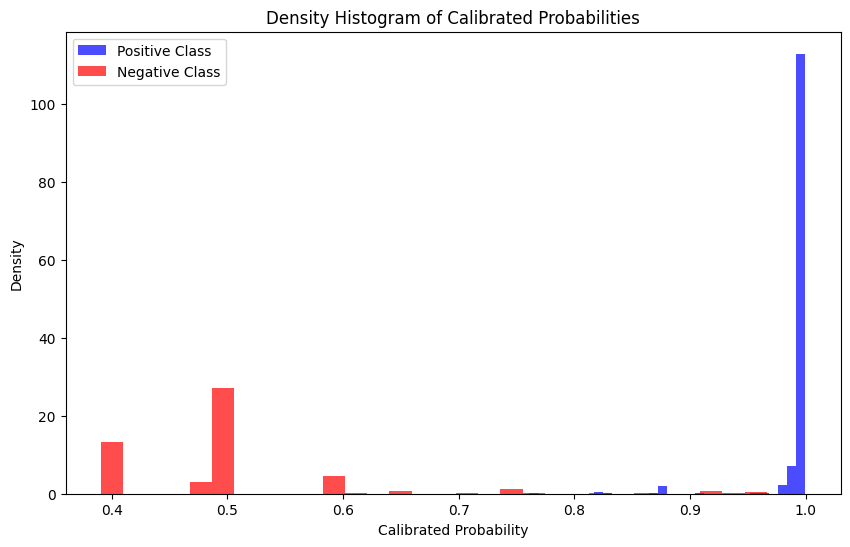

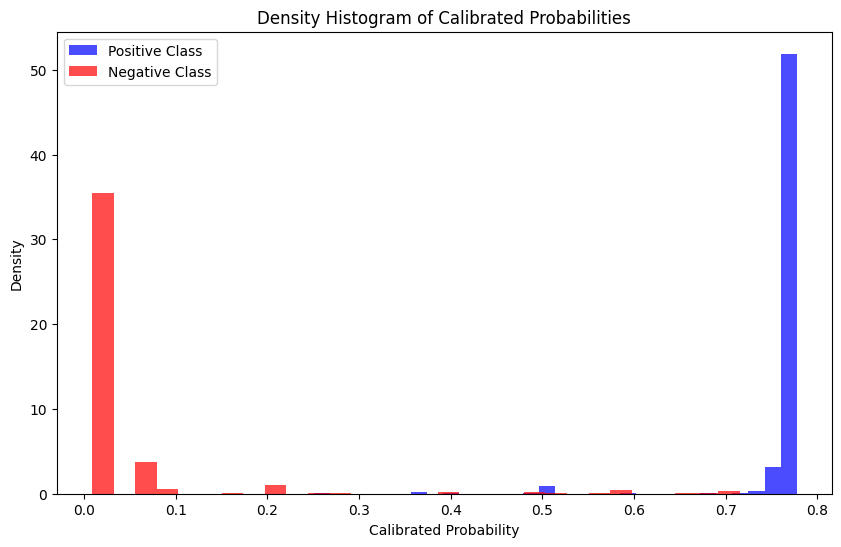

In [17]:
# Get the calibrated probabilities
calibrated_probabilities = pd_['P']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[pd_['Ever90'] == 1]
negative_class = calibrated_probabilities[pd_['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()

# Get the calibrated probabilities
calibrated_probabilities = pd_['BehaviourModel']

# Split the data into positive and negative classes
positive_class = calibrated_probabilities[pd_['Ever90'] == 1]
negative_class = calibrated_probabilities[pd_['Ever90'] == 0]

# Plot density histograms of calibrated probabilities
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, density=True, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, density=True, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Density')
plt.title('Density Histogram of Calibrated Probabilities')
plt.legend()
plt.show()



In [18]:
pd_ = pd_[['AccountNumber','AccountStatus','SnapshotDate',	'MOB'	,'DisbursedDate',	'CurrentAmount','RemainingTenor','CoappFlag',	'Ever30In6Months',	'WorstDelinquency6M','CurrentDelinquencyStatus','WorstDelinquency12M','Ever30In12Months','Ever90In12Months'	,'Score'	,'RiskClass','P','BehaviourModel','Ever90']]

In [19]:
pd_

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
1,7715436,CLOSED,2024-01-31,23,2022-02-10,0.00,174,0,0,0,0,0,0,0,NaN,NaN,0.500000,0.025065,0
4,7686272,CLOSED,2023-12-31,25,2021-11-03,0.00,1,0,0,0,0,0,0,0,NaN,NaN,0.500000,0.025065,0
5,5311071,CLOSED,2024-01-31,67,2018-06-29,0.00,111,0,0,0,0,0,0,0,NaN,NaN,0.500000,0.025065,0
7,7261803,CLOSED,2023-12-31,31,2021-05-19,0.00,0,0,0,0,0,0,0,0,NaN,NaN,0.500000,0.025065,0
8,7849581,OPEN,2023-12-31,12,2022-12-12,159516.23,131,0,0,1,0,1,0,0,4.595843,E4,0.587576,0.057309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55081,7396070,OPEN,2023-12-31,52,2019-08-21,101214.67,44,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0
55087,5343314,CLOSED,2023-11-30,63,2018-08-17,0.00,122,1,1,5,9,5,1,1,NaN,NaN,0.999602,0.777071,1
55088,7663727,FROZEN,2023-11-30,48,2019-11-29,258448.66,89,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
55090,7697147,FROZEN,2023-11-30,23,2021-12-06,358047.14,165,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1


In [20]:
print(np.mean(pd_.P))
min(pd_.P)

0.574733627244161


0.3907534979348959

In [21]:
print(np.mean(pd_.BehaviourModel))
max(pd_.BehaviourModel)

0.15588783165177916


0.7773140874043875

In [22]:
print(np.mean(see.P))
min(see.P)

0.6129005675918375


0.3907534979348959

In [23]:
pd_.tail(40)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
54892,7790934,FROZEN,2023-12-31,16,2022-08-16,408660.07,168,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
54893,5033139,FROZEN,2023-12-31,74,2017-10-04,163276.96,123,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
54898,7207202,FROZEN,2023-11-30,37,2020-10-30,290068.12,150,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
54903,7389109,FROZEN,2023-11-30,51,2019-08-07,320887.06,143,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
54906,7119837,CLOSED,2024-01-31,48,2020-01-02,0.00,29,1,1,5,9,5,1,1,NaN,NaN,0.999602,0.777071,1
54910,5006895,CLOSED,2024-01-31,83,2017-02-23,0.00,94,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
54913,5193313,CLOSED,2023-12-31,70,2018-02-23,0.00,33,1,1,5,9,5,1,1,NaN,NaN,0.999602,0.777071,1
54919,7138779,CLOSED,2023-12-31,46,2020-02-21,0.00,0,1,0,0,0,0,0,0,NaN,NaN,0.390753,0.008711,0
54925,7212673,FROZEN,2023-11-30,36,2020-11-23,467560.11,158,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1
54927,7209836,FROZEN,2023-11-30,36,2020-11-05,457835.63,156,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1


In [24]:
BehaviourDone = pd_.copy()

In [25]:
BehaviourDone[BehaviourDone.AccountNumber ==  7257967].sort_values(by='MOB')

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90
26430,7257967,OPEN,2023-11-30,30,2021-05-17,258257.52,148,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0
19984,7257967,OPEN,2023-12-31,31,2021-05-17,257658.27,147,0,1,2,1,2,1,0,39.215327,E5,0.831666,0.400923,0
19597,7257967,OPEN,2024-01-31,32,2021-05-17,256287.73,146,0,1,2,0,2,1,0,7.516150,E4,0.710064,0.168458,0


In [26]:
# Assuming 'BehaviourDone' is your DataFrame and it includes a 'P_calibrated' column along with the other specified columns

# Group the DataFrame by the specified columns and count the number of occurrences in each group
grouped_counts = BehaviourDone.groupby(['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus']).size()

# Convert the resulting series to a DataFrame and reset the index, which turns the grouped columns into regular columns and adds a new 'Counts' column with the group counts
grouped_counts_df = grouped_counts.reset_index(name='Counts')

# Sort the DataFrame based on the specified columns. The 'ascending' list determines the sort order for each column (True for ascending, False for descending).
sorted_counts_df = grouped_counts_df.sort_values(by=['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus'], ascending=[True, True, True, True, True])

# Display the sorted DataFrame, which includes the counts for each unique combination of the group-by columns
sorted_counts_df['Counts%'] = sorted_counts_df['Counts'] / sum(sorted_counts_df['Counts'])
sorted_counts_df

,BehaviourModel,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,Counts,Counts%
0,0.008711,1,0,0,0,9102,0.217694
1,0.020187,1,0,1,0,2141,0.051207
2,0.025065,0,0,0,0,18518,0.442898
3,0.057309,0,0,1,0,3049,0.072923
4,0.071093,1,1,2,0,46,0.001100
5,0.099436,1,0,1,1,503,0.012030
6,0.144000,1,1,3,0,7,0.000167
7,0.168458,0,1,2,0,67,0.001602
8,0.216872,0,0,1,1,866,0.020712
9,0.248860,1,1,2,1,71,0.001698


# 2. Application Scores

In [28]:

main_path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Admission-Scorecard-DATA-196/DATA/MA Correct join - APL CRB-MLP Today.sql"
co_path = "/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Admission-Scorecard-DATA-196/DATA/CO Min score join - APL CBR MLP Today.sql"

preprocessor = DataPreprocessor(server, database, username, password,driver)
final_df = preprocessor.process_data(main_path, co_path)


/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, con=self.conn)
/Users/andreasnilsson/Library/CloudStorage/OneDrive-Nstart/Skrivbordet/Repository Homes/Behavior_Scorecard-DATA-223/2. Code/Classes/Preprocessing_Application_N.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PropertyVolume'] = np.where( df.MortgageLoansHouseVolume > 0, df.MortgageLoansHouseVolume,


In [29]:
final_df

,RowNumber,Ever30,Ever90,AccountNumber,ApplicationID,SSN_A,PDScoreNew,ApplicationScore,IsMainApplicant,HasCoapp,...,SharedVolumeCrerditAccounts,UtilizationRatio,CreditAccountOverdraft,NumberOfMortgageLoans,SharedVolumeMortgageLoans,SharedVolumeCreditCards,Applicationtype,RowNum,age,PropertyVolume
227,1.0,0.0,0.0,5004296,5004296,69C8A21CAFFDEE2706ECB2A6747E9A99BB928C9CB1E18A...,NaN,2.230471,1,0,...,0.0,23.56,Nej,-1.0,-1.0,0.0,0.0,NaN,48,0.0
1,NaN,0.0,0.0,5004320,5004320,8960FE02B09C1BCBD06B555EC993D2A47FBDD5BFA0C64E...,NaN,0.335849,0,1,...,29167.0,72.18,Ja,-1.0,-1.0,23960.0,1.0,1.0,57,0.0
0,NaN,0.0,0.0,5004254,5004254,4B2066BF983333981D11C398D4F5F497A6A66AB887C65F...,NaN,0.837495,1,1,...,0.0,0.00,Nej,-1.0,-1.0,0.0,1.0,1.0,40,0.0
234,1.0,0.0,0.0,5004551,5004551,E63A283916669FA666387284A43561E1DD68CE044FE9D9...,NaN,5.408479,1,0,...,0.0,72.15,Nej,-1.0,-1.0,0.0,0.0,NaN,35,0.0
235,1.0,0.0,0.0,5004569,5004569,2554C473AF4A2215342B0EC264551936C88479DF897459...,NaN,0.335849,1,0,...,0.0,96.64,Nej,-1.0,-1.0,0.0,0.0,NaN,47,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9500,1.0,NaN,NaN,9003617,8960252,928E5C8B1C436BD7B22672769E1EDD1FC879A5E0AF68F9...,0.130136,3.054894,1,0,...,-1.0,-100.00,Unknown,-1.0,-1.0,-1.0,0.0,NaN,28,0.0
9501,1.0,NaN,NaN,9003633,8959961,CE0BE56C95221A6365C00C0C4CACF203AD909E6EA9BB7C...,0.087894,4.272936,1,0,...,0.0,99.92,Nej,-1.0,-1.0,0.0,0.0,NaN,32,0.0
9502,1.0,NaN,NaN,9003690,8960338,DDEE40E50FAED43627F7CA2EDEA94BE5B7B9EEFD6C742A...,0.069425,3.054894,1,0,...,0.0,96.44,Nej,-1.0,-1.0,0.0,0.0,NaN,27,0.0
4436,NaN,NaN,NaN,9003344,8959660,1D80007A7E0F07381637BFAEB0DA4AD5D652FE32B5FF29...,NaN,1.150730,0,1,...,0.0,0.00,Nej,3.0,0.0,0.0,1.0,1.0,33,875210.0


In [30]:
pd_ = final_df[['SSN','PDScoreNew','UCScore','age' ,'Inquiries12M','UtilizationRatio','Amount','MaritalStatus','ReceivedDate','DisbursedDate','Applicationtype','Ever90','Ever30','AccountNumber','CapitalDeficit','PropertyVolume','PaymentRemarks','IndebtednessRatio','ApplicationScore', 'StartupFee','PaymentRemarksNo'] ]



In [31]:
pd_[pd_.AccountNumber  =='5300405' ]

,SSN,PDScoreNew,UCScore,age,Inquiries12M,UtilizationRatio,Amount,MaritalStatus,ReceivedDate,DisbursedDate,...,Ever90,Ever30,AccountNumber,CapitalDeficit,PropertyVolume,PaymentRemarks,IndebtednessRatio,ApplicationScore,StartupFee,PaymentRemarksNo
511,Unknown,NaN,0.591,34,8.0,81.95,250000.0,MARRIED,2018-06-13,2018-06-26,...,0.0,0.0,5300405,21.0,0.0,1,0.6793,5.169574,NaN,8.0


In [32]:
max(pd_.DisbursedDate)

datetime.date(2024, 2, 14)

In [33]:
len(set(pd_.AccountNumber))

13513

In [38]:
import datetime as dt

In [45]:
import datetime as dt
import pandas as pd

# Assuming pd_ is your DataFrame and it's already defined

# Get the current date
now = dt.datetime.now()

# Get the first day of the current month
first_day_of_month = dt.datetime(now.year, now.month, 1)

# Ensure 'DisbursedDate' is in datetime format if it's not already
pd_['DisbursedDate'] = pd.to_datetime(pd_['DisbursedDate'])

# Filter the DataFrame for rows where 'DisbursedDate' is less than the first day of the current month
pd_ = pd_[pd_['DisbursedDate'] < first_day_of_month]

# Print the maximum 'DisbursedDate' from the filtered DataFrame
print(pd_['DisbursedDate'].max())


2024-01-31 00:00:00


/var/folders/xv/px633rpn27q5n8m3579ly8dm0000gn/T/ipykernel_20926/1090053723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_['DisbursedDate'] = pd.to_datetime(pd_['DisbursedDate'])


In [46]:
# Coefficients and Intercept from the Logistic Regression model
coefficients = np.array([2.03675292e+00 ,-2.18071234e-02  ,3.39715771e-02, -2.12322589e-07])  
intercept = np.array([-0.13407141])

print("Coefficients:", coefficients)
print("Intercept:", intercept)


# Compute the Z values using your logistic regression model
pd_['Z'] = (pd_.UCScore * coefficients[0] +
            pd_.age * coefficients[1] + 
            pd_.Inquiries12M * coefficients[2] +
            pd_.PropertyVolume * coefficients[3] + 
            intercept[0]) 

# Compute the original probabilities
pd_['P'] = pd_['Z'].apply(lambda x: 1 / (1 + np.exp(-x)))

# Coefficients and Intercept from the Calibration model
calibration_coef = 3.7812065422080856
calibration_intercept = -4.336067082588543



print("Coefficient:", calibration_coef)
print("Intercept:", calibration_intercept)

# Using the original probabilities to calibrate them with the calibration model
pd_['Z_calibrated'] = pd_['P'].apply(lambda x: x * calibration_coef + calibration_intercept)

# Compute the calibrated probabilities
pd_['AdmissionModel'] = pd_['Z_calibrated'].apply(lambda x: 1 / (1 + np.exp(-x)))

Coefficients: [ 2.03675292e+00 -2.18071234e-02  3.39715771e-02 -2.12322589e-07]
Intercept: [-0.13407141]
Coefficient: 3.7812065422080856
Intercept: -4.336067082588543


In [47]:
AdmissionDone = pd_[['AccountNumber','PDScoreNew','UCScore','age','Inquiries12M','PropertyVolume','AdmissionModel','ApplicationScore']]
AdmissionDone['AccountNumber'] = AdmissionDone['AccountNumber'].astype(int)

together = pd.merge(BehaviourDone,AdmissionDone , on='AccountNumber', how='outer')


## Only OPEN & FROZEN ACCOUNTS
lek = together[(together.AccountStatus.isin(['OPEN','FROZEN','COLLECTION']) )& (together.SnapshotDate == max(together.SnapshotDate) )]

/var/folders/xv/px633rpn27q5n8m3579ly8dm0000gn/T/ipykernel_20926/3502581355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AdmissionDone['AccountNumber'] = AdmissionDone['AccountNumber'].astype(int)


In [48]:
## 30 + stage 2 


# Assuming 'BehaviourDone' is your DataFrame and it includes a 'P_calibrated' column along with the other specified columns

# Group the DataFrame by the specified columns and count the number of occurrences in each group
grouped_counts = lek.groupby(['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus']).size()

# Convert the resulting series to a DataFrame and reset the index, which turns the grouped columns into regular columns and adds a new 'Counts' column with the group counts
grouped_counts_df = grouped_counts.reset_index(name='Counts')

# Sort the DataFrame based on the specified columns. The 'ascending' list determines the sort order for each column (True for ascending, False for descending).
sorted_counts_df = grouped_counts_df.sort_values(by=['BehaviourModel', 'CoappFlag', 'Ever30In6Months', 'WorstDelinquency6M', 'CurrentDelinquencyStatus'], ascending=[True, True, True, True, True])

# Display the sorted DataFrame, which includes the counts for each unique combination of the group-by columns
sorted_counts_df['Counts%'] = sorted_counts_df['Counts'] / sum(sorted_counts_df['Counts'])
sorted_counts_df

,BehaviourModel,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,Counts,Counts%
0,0.008711,1,0,0,0,1119,0.160545
1,0.020187,1,0,1,0,713,0.102296
2,0.025065,0,0,0,0,1976,0.283501
3,0.057309,0,0,1,0,953,0.136729
4,0.071093,1,1,2,0,21,0.003013
5,0.099436,1,0,1,1,169,0.024247
6,0.144000,1,1,3,0,3,0.000430
7,0.168458,0,1,2,0,25,0.003587
8,0.216872,0,0,1,1,303,0.043472
9,0.248860,1,1,2,1,24,0.003443


In [49]:
lek = together.copy()
lek = lek[(lek.AccountStatus.isin(['OPEN','FROZEN']) )]



lek['Stage'] = np.where(   lek.RiskClass.isin(['N1','N2','N3','E3','E4']), 'Stage1',
                np.where(   lek.RiskClass.isin(['E5','E6','E7']), 'Stage2',        
                         np.where(   lek.RiskClass.isin(['E8']), 'Stage3', 'check' )))

lek['Stage'].value_counts()

Stage
Stage1    14753
Stage3     3366
Stage2     2755
Name: count, dtype: int64

In [50]:
lek.RiskClass.value_counts()

RiskClass
E4    8824
E3    4766
E8    3366
E5    1673
E6     647
N1     583
N2     564
E7     435
N3      16
Name: count, dtype: int64

In [51]:
# Check unique values
unique_classes = lek['RiskClass'].unique()
print(unique_classes)

# Remove leading/trailing whitespace and convert to a consistent case (e.g., uppercase)
lek['RiskClass'] = lek['RiskClass'].str.strip().str.upper()

# Re-run your np.where logic after making the above adjustments


['E4' 'N2' 'E5' 'E3' 'N1' 'E8' 'E7' 'E6' 'N3']


In [52]:
lek.AdmissionModel 

12       0.126727
13       0.126727
14       0.126727
18       0.050708
19       0.050708
           ...   
41803    0.029824
41804    0.029824
41808    0.046373
41809    0.046373
41810    0.046373
Name: AdmissionModel, Length: 20874, dtype: float64

In [53]:
lek['AppliedApplicationScore'] = np.where(  lek.DisbursedDate > '2023-12-20' ,lek.AdmissionModel ,
                                 np.where( lek.DisbursedDate <= '2023-12-20' ,lek.ApplicationScore/100 ,
                               
                              -100000 ))

#min(lek['AppliedApplicationScore'])


In [54]:
max(lek.SnapshotDate)

'2024-01-31'

In [55]:
lek['AppliedApplicationScore'] = np.where(
    (lek['DisbursedDate'] > '2023-12-20') &
    (np.round(lek['PDScoreNew'], 2) <= np.round(lek['AdmissionModel'], 2)) &
    (lek['PDScoreNew'].notna()),  # Condition for the first case
    lek['PDScoreNew'],  # Result if the first condition is True

    np.where(
        (lek['DisbursedDate'] > '2023-12-20') &
        
        lek['PDScoreNew'].isna(),  # Condition for the second case when PDScoreNew is NaN
        lek['AdmissionModel'],  # Result if the second condition is True

        np.where(
            (lek['DisbursedDate'] <= '2023-12-20'),  # Condition for the third case
            lek['ApplicationScore'] / 100,  # Result if the third condition is True
            lek['AdmissionModel'] # Default result if no conditions are met
        )
    )
)



pd.set_option('display.max_columns', None)

# 

In [56]:
# frame = lek[lek.DisbursedDate > '2023-12-31']


# # print(max(frame['AppliedApplicationScore']))

# # frame.sort_values(by= 'AdmissionModel').tail(20)

# np.mean(frame.AppliedApplicationScore)


# frame[ (lek['PDScoreNew'].notna()) &    (np.round(lek['PDScoreNew'], 2) != np.round(lek['AdmissionModel'], 2))]

#frame[ (lek['PDScoreNew'].notna()) &    (np.round(lek['PDScoreNew'], 2) == np.round(lek['AdmissionModel'], 2))].sort_values('UCScore')

In [57]:



lek['AdjustedBehaviourScore'] = np.where(  lek['BehaviourModel'] > 0.744587 ,1.0 , lek['BehaviourModel'])


see = lek.copy()


see['AppliedApplicationScore'] = np.where(  see.AppliedApplicationScore.isna()   ,0 , see.AppliedApplicationScore )


see['PD_Delta'] = see.AdjustedBehaviourScore - see.AppliedApplicationScore 


see = see[see.MOB.notna()]   ## take away accounts that was closed last month

see['PD_Delta'] = np.where(see['PD_Delta'].isna() , 0,see['PD_Delta'])

see = see.sort_values(by='PD_Delta')

see['SICR'] = np.where(see.PD_Delta > 	0.211944 ,1,0)



In [58]:



see[see.SICR ==0].tail(20)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR
20135,7227150,OPEN,2023-12-31,35,2021-01-22,181756.93,145,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.011,53.0,19.0,610383.0,0.042117,0.493233,Stage2,0.004932,0.216872,0.21194,0
20134,7227150,OPEN,2024-01-31,36,2021-01-22,181243.66,144,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.011,53.0,19.0,610383.0,0.042117,0.493233,Stage2,0.004932,0.216872,0.21194,0
9527,7724487,OPEN,2023-12-31,21,2022-03-01,196823.07,98,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.094,46.0,10.0,0.0,0.047361,0.493233,Stage2,0.004932,0.216872,0.21194,0
3067,7773914,OPEN,2023-12-31,17,2022-07-06,268605.45,114,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.020,57.0,6.0,1047000.0,0.027636,0.493233,Stage2,0.004932,0.216872,0.21194,0
9428,5044292,OPEN,2024-01-31,74,2017-11-17,64409.20,70,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.025,57.0,2.0,0.0,0.029331,0.493233,Stage2,0.004932,0.216872,0.21194,0
897,7682750,OPEN,2023-11-30,25,2021-10-22,204731.47,71,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.095,45.0,13.0,0.0,0.052604,0.493233,Stage2,0.004932,0.216872,0.21194,0
5586,7728041,OPEN,2023-11-30,20,2022-03-08,98081.20,159,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.098,48.0,15.0,1470132.0,0.041066,0.493233,Stage2,0.004932,0.216872,0.21194,0
2280,7264732,OPEN,2023-11-30,30,2021-05-26,169040.50,90,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.077,59.0,9.0,0.0,0.035995,0.493233,Stage2,0.004932,0.216872,0.21194,0
20682,7706831,OPEN,2024-01-31,24,2022-01-07,177370.71,155,0,0,1,1,1,0,0,27.662599,E5,0.741876,0.216872,0,NaN,0.034,45.0,13.0,0.0,0.047420,0.493233,Stage2,0.004932,0.216872,0.21194,0
12117,5833918,OPEN,2023-12-31,56,2019-04-29,35169.10,16,0,0,1,1,1,0,0,39.215327,E5,0.741876,0.216872,0,NaN,0.080,52.0,6.0,0.0,0.037540,0.493233,Stage2,0.004932,0.216872,0.21194,0


In [59]:
see[(see.Ever90In12Months ==1 ) & (see.SICR ==0)].tail(30)

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR


In [60]:
## Apply a lifetime factor, this is based from UCBLANCO VINTAGE ANALYSIS, in lower risk but still high 20 % increase and on the rest it will be 10 % increase

see['AdjustedBehaviourScore'] = np.where( (see['SICR'] == 1) &(see['AdjustedBehaviourScore'] < 0.50) , see.AdjustedBehaviourScore * 1.2 , 
                      np.where( (see['SICR'] == 1) &(see['AdjustedBehaviourScore'] >= 0.50) , see.AdjustedBehaviourScore * 1.1 ,   see.AdjustedBehaviourScore )) ## Adding LifeTime Convertion to Stage 2 


see['AdjustedBehaviourScore'] = np.where( see.AdjustedBehaviourScore > 1,1,see.AdjustedBehaviourScore)



see['Stageing'] = np.where(   see['SICR'] == 0 ,'Stage1',
                           np.where(   see['AdjustedBehaviourScore'] == 1 ,'Stage3','Stage2'))



In [61]:
#max(see.SnapshotDate)

see = see[(see.SnapshotDate != max(see.SnapshotDate))]


print(min(see.SnapshotDate))

2023-11-30


In [62]:
see

,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing
36630,7100258,OPEN,2023-11-30,54,2019-05-27,81020.13,66,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.189630,0,Stage1
36628,7100258,OPEN,2023-12-31,55,2019-05-27,80486.35,65,1,0,0,0,0,0,0,1.484099,E3,0.390753,0.008711,0,NaN,0.574,56.0,1.0,0.0,0.069846,19.834029,Stage1,0.19834,0.008711,-0.189630,0,Stage1
3838,7708423,OPEN,2023-11-30,22,2022-01-13,114941.81,62,0,0,0,0,0,0,0,7.516150,E4,0.500000,0.025065,0,NaN,0.524,26.0,9.0,0.0,0.137865,19.834029,Stage1,0.19834,0.025065,-0.173275,0,Stage1
12121,7746431,OPEN,2023-12-31,19,2022-05-10,64155.83,160,0,0,0,0,0,0,0,3.654435,E4,0.500000,0.025065,0,NaN,0.634,24.0,16.0,0.0,0.190709,19.834029,Stage1,0.19834,0.025065,-0.173275,0,Stage1
12122,7746431,OPEN,2023-11-30,18,2022-05-10,64202.87,161,0,0,0,0,0,0,0,3.654435,E4,0.500000,0.025065,0,NaN,0.634,24.0,16.0,0.0,0.190709,19.834029,Stage1,0.19834,0.025065,-0.173275,0,Stage1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11524,5001698,FROZEN,2023-12-31,91,2016-05-20,146727.94,125,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.000000,1,Stage3
27456,5003603,FROZEN,2023-11-30,83,2016-12-12,47223.06,138,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.000000,1,Stage3
27454,5003603,FROZEN,2023-12-31,84,2016-12-12,46716.06,138,0,1,5,9,5,1,1,100.000000,E8,0.999745,0.777314,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.000000,1,Stage3
41041,5002134,FROZEN,2023-12-31,89,2016-07-04,180493.76,106,1,1,5,9,5,1,1,100.000000,E8,0.999602,0.777071,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stage3,0.00000,1.000000,1.000000,1,Stage3


In [63]:
save = see[(see.SnapshotDate == max(see.SnapshotDate))]

new = see[(see.SnapshotDate != max(see.SnapshotDate))]
new = new[(new.SnapshotDate == max(new.SnapshotDate))]


new = new[['AccountNumber','AdjustedBehaviourScore','SnapshotDate','Stage','Stageing','CurrentAmount']]

vaR = (len(new.columns)-1)*(-1)

# Get the list of column names
columns = new.columns.tolist()

# Select the last two column names
last_two_columns = columns[vaR:]

# Create a dictionary that maps the old column names to the new ones with '_1m' suffix
rename_dict = {col: f"{col}_1m" for col in last_two_columns}

# Rename the last two columns
new_renamed = new.rename(columns=rename_dict)

see = pd.merge(  save, new_renamed , on='AccountNumber',how='outer')

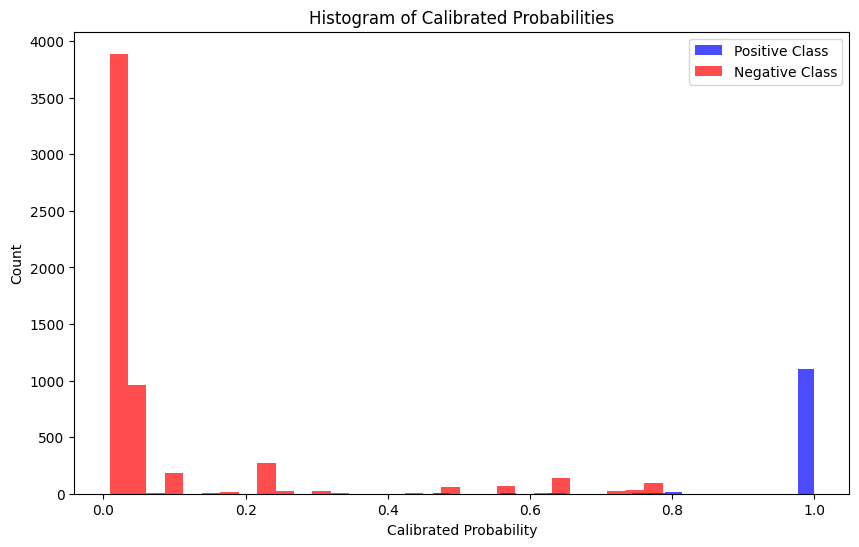

In [64]:
import matplotlib.pyplot as plt

# Get the calibrated probabilities
calibrated_probabilities = see['AdjustedBehaviourScore']

# Split the data into positive and negative classes based on the updated requirement
positive_class = calibrated_probabilities[see['Ever90'] == 1]
negative_class = calibrated_probabilities[see['Ever90'] == 0]

# Plot histograms of calibrated probabilities with actual counts instead of density
plt.figure(figsize=(10, 6))
plt.hist(positive_class, bins=30, color='blue', alpha=0.7, label='Positive Class')
plt.hist(negative_class, bins=30, color='red', alpha=0.7, label='Negative Class')
plt.xlabel('Calibrated Probability')
plt.ylabel('Count')
plt.title('Histogram of Calibrated Probabilities')
plt.legend()
plt.show()




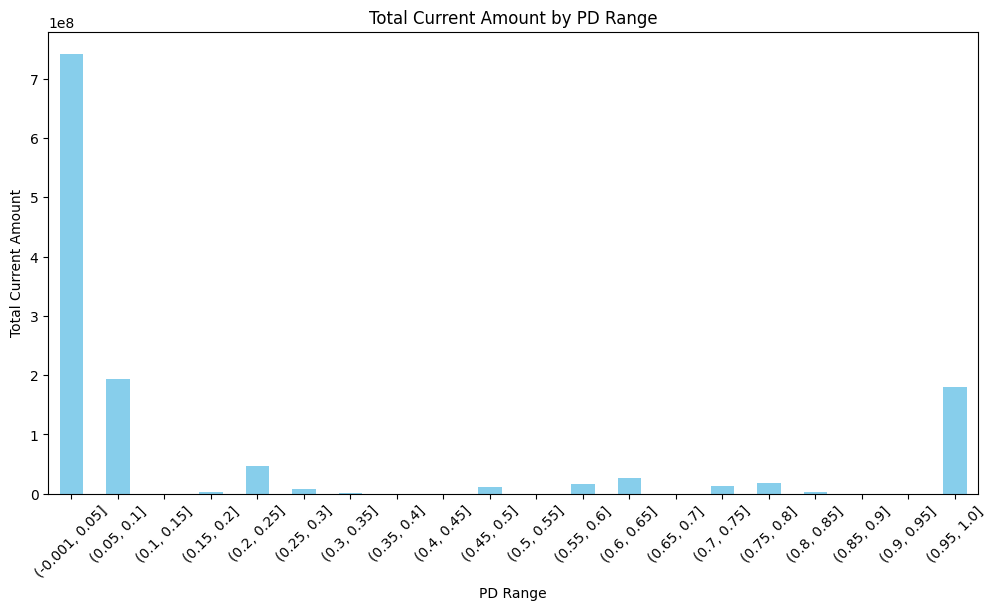

In [65]:

tt = see.copy()


# Define PD ranges (for example, 0-0.1, 0.1-0.2, ..., 0.9-1.0)
pd_bins = np.linspace(0, 1, 21)  # 10 equal intervals from 0 to 1
tt['PDCategory'] = pd.cut(tt['AdjustedBehaviourScore'], pd_bins, include_lowest=True, right=True)

# Group by PD category and sum 'CurrentAmount' within each category
pd_grouped = tt.groupby('PDCategory')['CurrentAmount'].sum()

# Plot
plt.figure(figsize=(12, 6))
pd_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('PD Range')
plt.ylabel('Total Current Amount')
plt.title('Total Current Amount by PD Range')
plt.xticks(rotation=45)
plt.show()

In [66]:
print(np.min(see['AdjustedBehaviourScore']))
print(np.max(see['AdjustedBehaviourScore']))
print(np.mean(see['AdjustedBehaviourScore']))

print(np.mean(see['Score']))

0.008710691203618422
1.0
0.23364580699782775
24.332615896410076


In [67]:
print(np.mean(see[see.Stageing == 'Stage1'].AdjustedBehaviourScore))

print(np.mean(see[see.Stageing == 'Stage2'].AdjustedBehaviourScore))

0.03992091304599101
0.6256695703307511


In [68]:
see[(see.Stage == 'Stage2')& (see.Stageing == 'Stage1')].tail(20)


,AccountNumber,AccountStatus,SnapshotDate,MOB,DisbursedDate,CurrentAmount,RemainingTenor,CoappFlag,Ever30In6Months,WorstDelinquency6M,CurrentDelinquencyStatus,WorstDelinquency12M,Ever30In12Months,Ever90In12Months,Score,RiskClass,P,BehaviourModel,Ever90,PDScoreNew,UCScore,age,Inquiries12M,PropertyVolume,AdmissionModel,ApplicationScore,Stage,AppliedApplicationScore,AdjustedBehaviourScore,PD_Delta,SICR,Stageing,AdjustedBehaviourScore_1m,SnapshotDate_1m,Stage_1m,Stageing_1m,CurrentAmount_1m
5319,7908338,OPEN,2023-12-31,7.0,2023-05-08,292812.04,160.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.071,54.0,5.0,0.0,0.034991,0.945136,Stage2,0.009451,0.216872,0.207421,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,292812.04
5320,7227556,OPEN,2023-12-31,33.0,2021-03-01,178277.60,205.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.052,37.0,2.0,1113120.0,0.034835,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,178277.60
5321,7247489,OPEN,2023-12-31,32.0,2021-04-08,115369.08,87.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.044,41.0,4.0,0.0,0.040467,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,115369.08
5322,7719909,OPEN,2023-12-31,22.0,2022-02-11,92529.73,158.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.060,29.0,35.0,0.0,0.125330,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,92529.73
5323,7745912,OPEN,2023-12-31,19.0,2022-05-09,158836.76,160.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.072,29.0,32.0,0.0,0.117987,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,158836.76
5324,7744204,OPEN,2023-12-31,20.0,2022-04-27,37087.33,40.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.027,38.0,5.0,0.0,0.042575,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,37087.33
5325,7245574,OPEN,2023-12-31,32.0,2021-04-21,125026.22,40.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,39.215327,E5,0.741876,0.216872,0.0,NaN,0.085,29.0,10.0,0.0,0.063927,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.216872,2023-11-30,Stage2,Stage1,128112.23
5326,7176019,OPEN,2023-12-31,41.0,2020-07-01,33233.06,30.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.099,35.0,16.0,0.0,0.069850,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.057309,2023-11-30,Stage1,Stage1,33233.06
5327,7757313,OPEN,2023-12-31,19.0,2022-05-31,95926.09,125.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.041,33.0,4.0,0.0,0.046276,0.837495,Stage2,0.008375,0.216872,0.208497,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,95926.09
5328,7827751,OPEN,2023-12-31,14.0,2022-10-27,281751.94,166.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,27.662599,E5,0.741876,0.216872,0.0,NaN,0.092,43.0,10.0,1037220.0,0.041677,0.669086,Stage2,0.006691,0.216872,0.210181,0.0,Stage1,0.025065,2023-11-30,Stage1,Stage1,281751.94


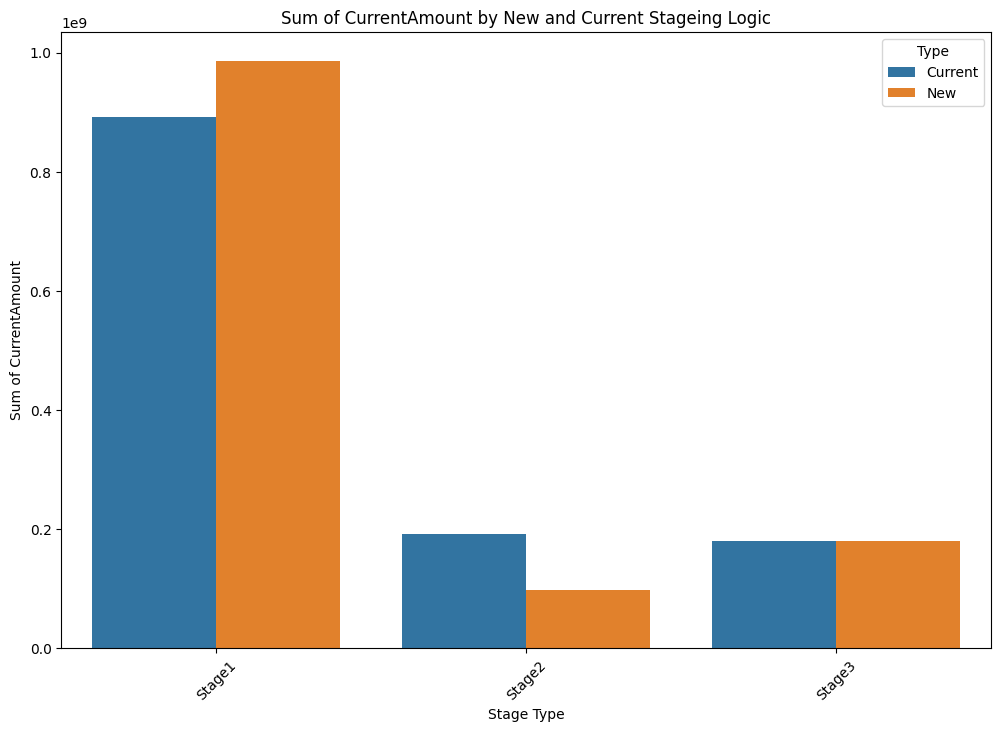

In [69]:

import seaborn as sns

see.groupby('Stage')['CurrentAmount'].sum()
see.groupby('Stageing')['CurrentAmount'].sum()

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stage')['CurrentAmount'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stageing')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stage': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stageing': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'Current'
stageing_sum['Type'] = 'New'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Sum of CurrentAmount by New and Current Stageing Logic')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


## skillnade är att om de blir sen med en faktura vilket kan vara 6 dagar så kommer de hoppa i den tidigare, den nya säger att först från 2 fakturor sen så är det mer kritiskt


Också att om de har varit 30 + senaste 12 månaderna

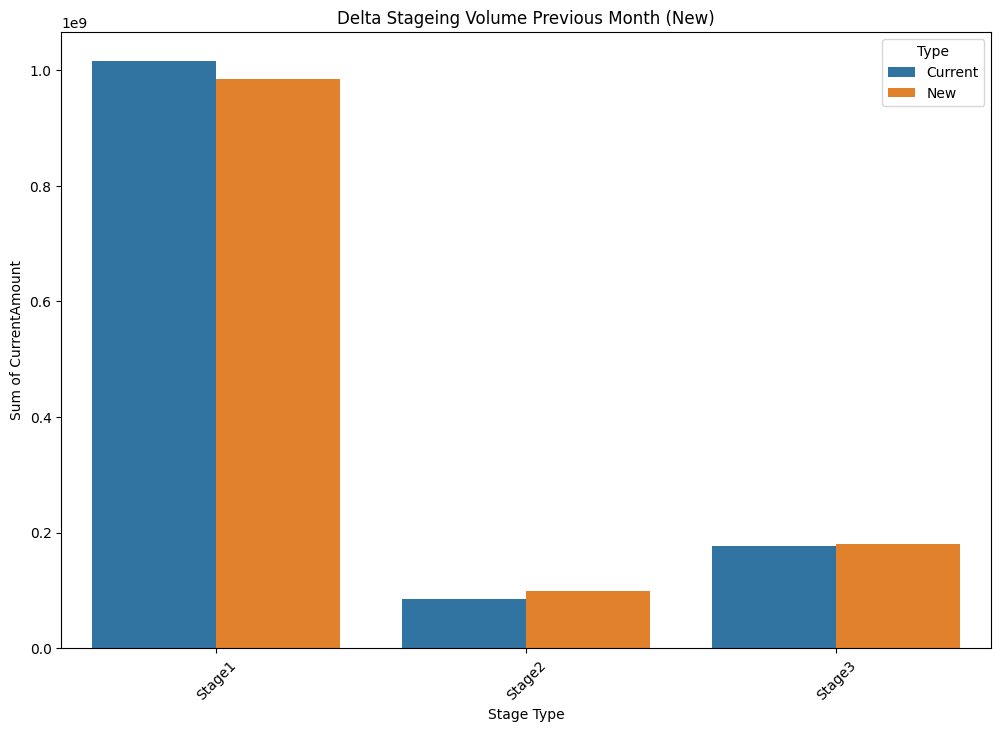

In [70]:

import seaborn as sns

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stageing_1m')['CurrentAmount_1m'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stageing')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stageing_1m': 'StageType', 'CurrentAmount_1m': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stageing': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'Current'
stageing_sum['Type'] = 'New'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Delta Stageing Volume Previous Month (New)')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


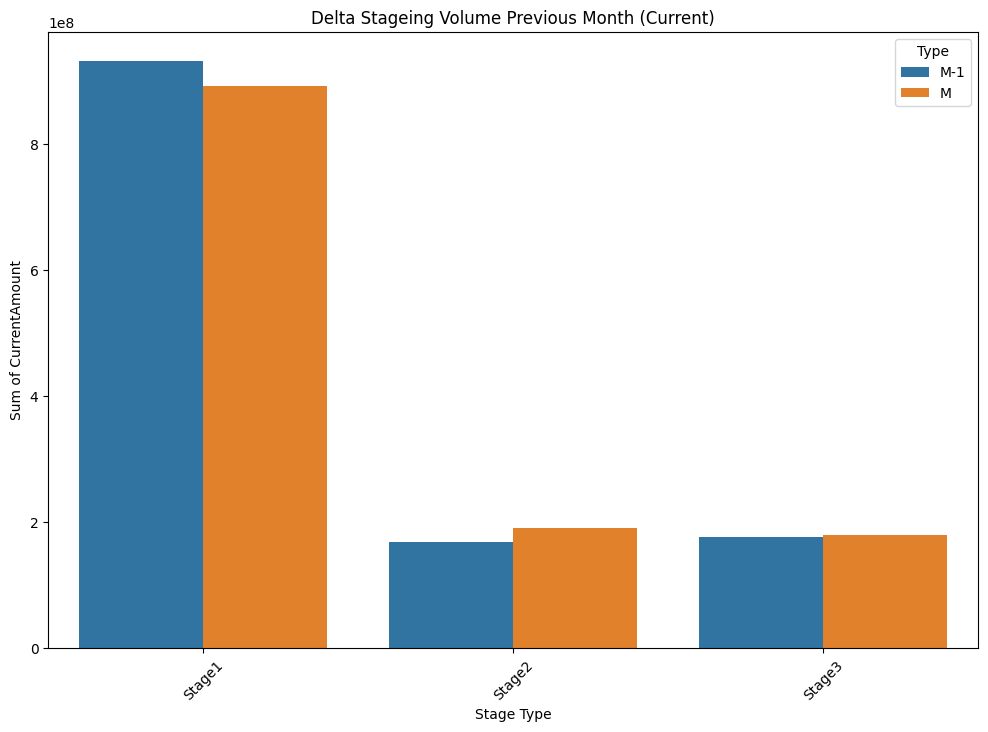

In [71]:

import seaborn as sns

# Assuming 'see' is your DataFrame and it's already loaded

# Calculate the sum of 'CurrentAmount' for each 'Stage'
stage_sum = see.groupby('Stage_1m')['CurrentAmount_1m'].sum().reset_index()

# Calculate the sum of 'CurrentAmount' for each 'Stageing'
stageing_sum = see.groupby('Stage')['CurrentAmount'].sum().reset_index()

# Rename the columns for concatenation
stage_sum.rename(columns={'Stage_1m': 'StageType', 'CurrentAmount_1m': 'SumAmount'}, inplace=True)
stageing_sum.rename(columns={'Stage': 'StageType', 'CurrentAmount': 'SumAmount'}, inplace=True)

# Add a new column to each DataFrame to distinguish between 'Stage' and 'Stageing'
stage_sum['Type'] = 'M-1'
stageing_sum['Type'] = 'M'

# Concatenate the two DataFrames
combined_sum = pd.concat([stage_sum, stageing_sum])

# Now, let's create the combined bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(x='StageType', y='SumAmount', hue='Type', data=combined_sum)
plt.title('Delta Stageing Volume Previous Month (Current)')
plt.ylabel('Sum of CurrentAmount')
plt.xlabel('Stage Type')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()


In [120]:
combined_sum

,StageType,SumAmount,Type
0,Stage1,9.317552e+08,M-1
1,Stage2,1.677097e+08,M-1
2,Stage3,1.759726e+08,M-1
0,Stage1,8.923883e+08,M
1,Stage2,1.914005e+08,M
2,Stage3,1.803811e+08,M


In [121]:
reporting = see[['AccountNumber','SnapshotDate','MOB','DisbursedDate','CurrentAmount','CurrentAmount_1m','AppliedScore','AppliedScore_1m','Stageing','Stageing_1m','PD_Delta','SICR']]
reporting

KeyError: "['AppliedScore', 'AppliedScore_1m'] not in index"